# matminer 示例1 从数据库获取数据

https://nbviewer.jupyter.org/github/hackingmaterials/matminer_examples/blob/master/matminer_examples/data_retrieval-nb/data_retrieval_basics.ipynb

## 从 Materials Project 数据库获取
从Materials Project数据库获取数据得用到 matminer.data_retrieval.retrieve_MP.MPDataRetrieval 功能。

In [1]:
from matminer.data_retrieval.retrieve_MP import MPDataRetrieval

In [2]:
mpdr = MPDataRetrieval(api_key='4okTua8FpUEIKNGg') # 在实例化 MPDataRetrieval 时需要输入用户在 Material Project 网站的 API Key.

### 示例1：获取所有单元素材料的密度

In [3]:
'''
上一次的介绍说到，matminer 处理的数据跟 pandas 库一样，是 dataframe，所以我们要用 get_dataframe 方法获取数据; 
dataframe 看起来就像excel 表格一样
'''

df = mpdr.get_dataframe(criteria={"nelements": 1}, properties=['density', 'pretty_formula'])

'''
criteria 是搜索条件，它是一个字典，字典里面可以有多个键值对; properties 是想要获取的材料性质，它是个列表，里面可以有多个性质。
其实criteria 也是材料的性质。
想知道所有可用的性质，请参考 https://github.com/materialsproject/pymatgen/blob/master/pymatgen/ext/matproj.py

上述代码意味着 我们想在数据库中搜索材料，这些材料元素种类为1，对于这些材料，我们想得到它们的密度和化学式信息。
'''

print("There are {} entries on MP with 1 element".format(df['density'].count())) # 计算有多少材料
#请自行关注 df['density'].count() 语句



There are 716 entries on MP with 1 element


In [4]:
df.head()  # 这个语句会显示 df 这个表格的前几行，可以看到，我们获得了 716 个单元素材料。
           # 表格里记录了我们需要的密度 和 化学式的性质，以及它们的ID

,density,pretty_formula
material_id,,
mp-1057273,9.879692,Pb
mp-611448,3.493678,C
mp-80,7.376651,Sb
mp-8636,8.147372,Nb
mp-557869,1.583355,S


### 示例2：获取所有带隙大于 4.0 eV的材料
方法挺简单的，就是在上个例子的 get_dataframe 方法中设置新的搜索条件: 带隙大于4.0 eV.

In [5]:
# 带隙是 band_gap，大于4怎么写呢？ 是 greater than, 缩写成 gt. 在 matminer中要写成 $gt 
# 大家注意体会 criteria 的字典形式。criteria=, properties= 可以省略不写。
df = mpdr.get_dataframe({"band_gap": {"$gt": 4.0}}, ['pretty_formula', 'band_gap'])

print("There are {} entries on MP with a band gap larger than 4.0".format(df['band_gap'].count()))

There are 8285 entries on MP with a band gap larger than 4.0


In [6]:
df.head()

,pretty_formula,band_gap
material_id,,
mp-10080,PrGeBO5,4.0136
mp-1020145,Na2Ge(S2O7)3,4.0030
mp-1021327,KLiICl,4.0542
mp-1029718,CsC2N3,4.0731
mp-1029920,Y2(CN2)3,4.0364


In [7]:
# df.to_csv() 可以方便地把数据保存成 .csv格式的文件，可以被excel直接打开和编辑
df.to_csv('materials_bg_gt_4.csv')

### 示例3：获取 VRH 剪切模量和体积模量
首先得要求这些材料存在弹性的性质，其次，我们还想要求这些弹性数据没有警告信息

In [8]:
# 存在弹性常数信息用 "elasticity": {"$exists": True} 表示，没有警告信息用 一个空列表表示："elasticity.warnings": []

df = mpdr.get_dataframe({"elasticity": {"$exists": True}, "elasticity.warnings": []},
                        ['pretty_formula', 'elasticity.K_VRH', 'elasticity.G_VRH'])

print("There are {} elastic entries on MP with no warnings".format(df['elasticity.K_VRH'].count()))

There are 8073 elastic entries on MP with no warnings


In [9]:
df.describe() # 该语句可以很方便地对表格中的每一列数据进行统计，给出数量，平均数，方差，最小、最大值等信息

,elasticity.K_VRH,elasticity.G_VRH
count,8073.000000,8073.000000
mean,111.460671,54.143317
std,77.298297,45.109616
min,2.000000,2.000000
25%,47.000000,22.000000
50%,98.000000,42.000000
75%,162.000000,75.000000
max,575.000000,525.000000


接下来让我们练习更加复杂的例子，这次我们还要提取材料的能带和DOS等信息

In [10]:
'''
除了上次的搜索条件外，我们想搜索包含 Pb 和 Te 的材料："elements": {"$all": ["Pb", "Te"]} 
材料的稳定性也在考虑之中，energy above hull 必须在1e-6以下："e_above_hull": {"$lt": 1e-6}
'''
df = mpdr.get_dataframe(criteria={"elasticity": {"$exists": True}, 
                         "elasticity.warnings": [],
                         "elements": {"$all": ["Pb", "Te"]},
                         "e_above_hull": {"$lt": 1e-6}}, # to limit the number of hits for the sake of time
                        properties = ["elasticity.K_VRH", "elasticity.G_VRH", "pretty_formula", 
                                      "e_above_hull", "bandstructure", "dos"])

print("There are {} elastic entries on MP with no warnings that contain "
      "Pb and Te with energy above hull ~ 0.0 eV".format(df['elasticity.K_VRH'].count()))


There are 3 elastic entries on MP with no warnings that contain Pb and Te with energy above hull ~ 0.0 eV


In [11]:
df.head()

,elasticity.K_VRH,elasticity.G_VRH,pretty_formula,e_above_hull,bandstructure,dos
material_id,,,,,,
mp-19717,40.0,24.0,TePb,0,<pymatgen.electronic_structure.bandstructure.B...,Complete DOS for Full Formula (Te1 Pb1)\nReduc...
mp-20740,25.0,13.0,Tl4Te3Pb,0,<pymatgen.electronic_structure.bandstructure.B...,Complete DOS for Full Formula (Tl8 Te6 Pb2)\nR...
mp-605028,34.0,16.0,Te2Pd3Pb2,0,<pymatgen.electronic_structure.bandstructure.B...,Complete DOS for Full Formula (Te4 Pd6 Pb4)\nR...


下面来查看一下其中一个材料的能带和DOS图

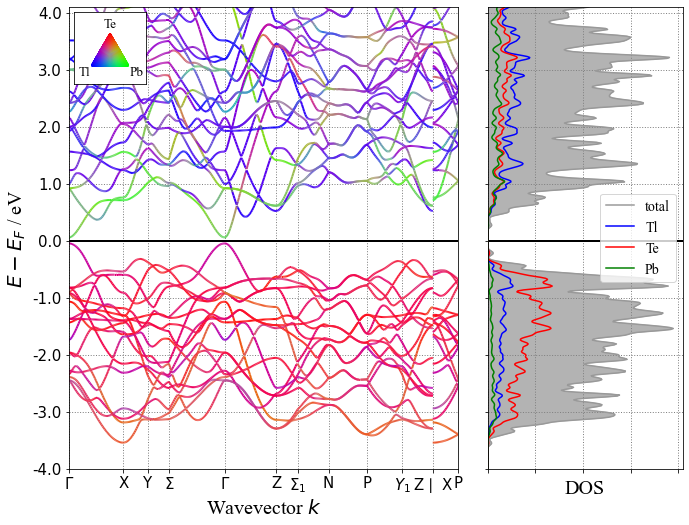

In [12]:
%matplotlib inline
# 这个 %matplotlib inline 语句很有用，它能够确保jupyter实时捕捉matplotlib画出来的图，并显示在这个文档中

from pymatgen.electronic_structure.plotter import BSDOSPlotter

mpid = 'mp-20740'
idx = df.index[df.index==mpid][0]  # 获取 mp-20740 这个材料所在的行数
plt = BSDOSPlotter().get_plot(bs=df.loc[idx, 'bandstructure'], dos=df.loc[idx, 'dos']);
plt.show()